In [7]:
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv

from segment_track.fastsam_wrapper import FastSAMWrapper, mask_bounding_box

from robot_utils.robot_data import ImgData, PoseData

In [2]:
device = 'cuda'
FASTSAM_WEIGHTS = '/home/lucas/Workspace/fastsam3d/FastSAM/weights/FastSAM-x.pt'

In [4]:
fastsam = FastSAMWrapper(
    weights=FASTSAM_WEIGHTS,
    device=device,
)
fastsam.setup_filtering(
    clip_embedding=True
)

In [5]:
img_data = ImgData.from_bag(
    path="/home/lucas/Downloads/runA.bag",
    topic="/RR08/l515/color/image_raw/compressed",
    compressed=True
)
pose_data = PoseData.from_bag(
    path="/home/lucas/Downloads/runA.bag",
    topic="/RR08/world"
)

<Axes: >

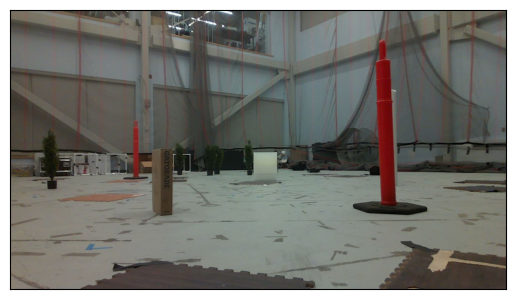

In [6]:
img = img_data.img(img_data.t0)
img_data.show(img_data.t0)

In [8]:
t = img_data.t0 + 1
img_org = img_data.img(t)
observations = fastsam.run(t, pose_data.T_WB(t), img_data.img(t))


0: 576x1024 30 objects, 115.8ms
Speed: 3.5ms preprocess, 115.8ms inference, 69.1ms postprocess per image at shape (1, 3, 1024, 1024)


<Axes: >

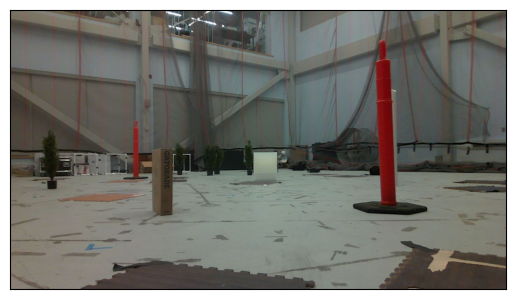

In [9]:
img_data.show(t)

In [10]:
print(len(observations))

30


### Inspect one of the created observations ###

In [11]:
def inspect_obs(img, observations, obs_idx):
    # mask_downsampled =  observations[obs_idx].mask_downsampled
    mask = observations[obs_idx].mask.astype('uint8')
    fig, axes = plt.subplots(1,2)
    img = cv.bitwise_and(img, img, mask = mask)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes[0].imshow(img)
    min_col, min_row, max_col, max_row = mask_bounding_box(mask)
    img_bbox = img[min_row:max_row, min_col:max_col]
    axes[1].imshow(img_bbox)

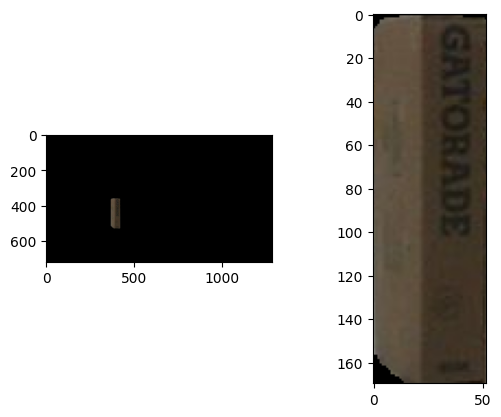

In [12]:
inspect_obs(img_org, observations, 0)

In [13]:
cosine_similarity = np.zeros((len(observations), len(observations)))
for i in range(len(observations)):
    for j in range(len(observations)):
        embedding_1 = observations[i].clip_embedding
        embedding_2 = observations[j].clip_embedding
        cosine_similarity[i, j] = np.dot(embedding_1, embedding_2)/(np.linalg.norm(embedding_1)*np.linalg.norm(embedding_2))

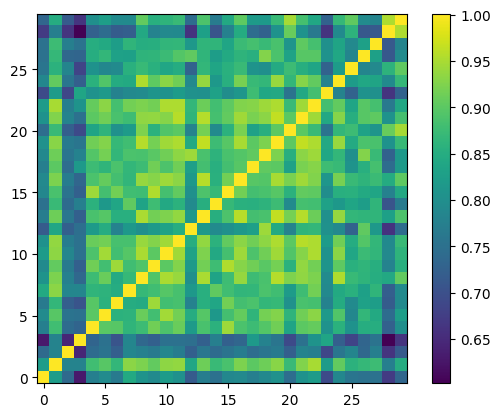

In [14]:
plt.close()
plt.imshow(cosine_similarity, vmin=cosine_similarity.min(), vmax=cosine_similarity.max(), interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

### Inspect segments with high similarity scores ###

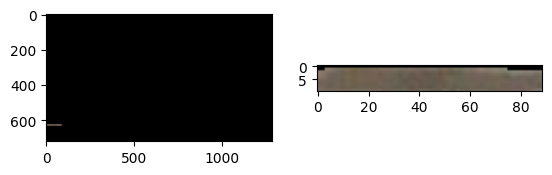

In [17]:
inspect_obs(img_org, observations, 28)

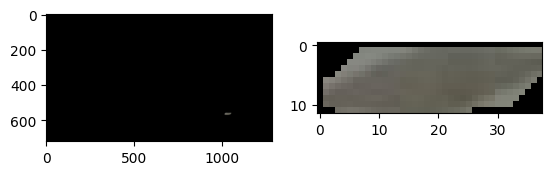

In [18]:
inspect_obs(img_org, observations, 29)

### Investigate Different Views of Same Objects ###

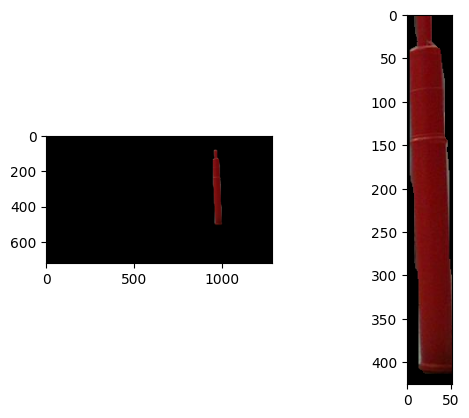

In [19]:
### Pick out the cones.
inspect_obs(img_org, observations, 7)

In [27]:
cone_embedding = observations[7].clip_embedding

In [28]:
t = img_data.t0 + 5
img_next = img_data.img(t)
observations_next = fastsam.run(t, pose_data.T_WB(t), img_data.img(t))


0: 576x1024 32 objects, 116.5ms
Speed: 3.2ms preprocess, 116.5ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)


<Axes: >

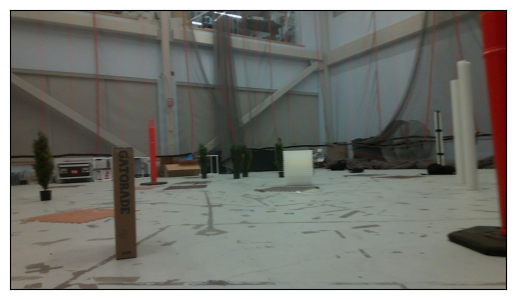

In [22]:
img_data.show(t)

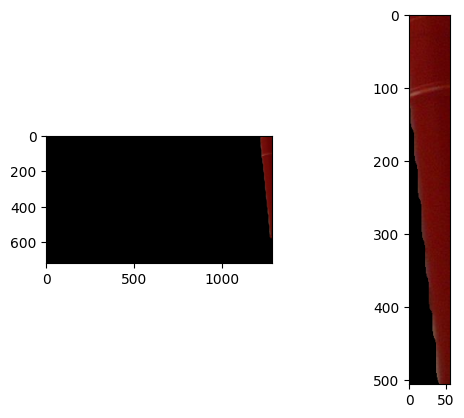

In [23]:
inspect_obs(img_next, observations_next, 11)

In [24]:
idx_diff_cone = 8 ### Index of the left cone
idx_same_cone = 11 ### Index of the right cone

In [25]:
cone_embeddings = [cone_embedding, observations_next[idx_diff_cone].clip_embedding, observations_next[idx_same_cone].clip_embedding]
M = np.zeros((len(cone_embeddings), len(cone_embeddings)))
for i in range(len(cone_embeddings)):
    for j in range(len(cone_embeddings)):
        M[i, j] = np.dot(cone_embeddings[i], cone_embeddings[j])/(np.linalg.norm(cone_embeddings[i])*np.linalg.norm(cone_embeddings[j]))
    

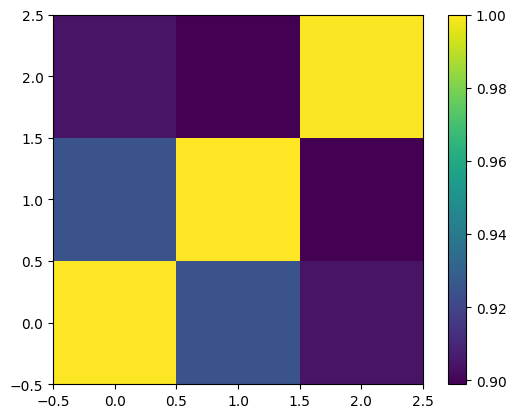

In [26]:
plt.close()
plt.imshow(M, vmin=M.min(), vmax=M.max(), interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()